In [1]:
import numpy as np
from geotiff import GeoTiff
import cv2
from skimage.measure import block_reduce
from matplotlib import pyplot as plt

In [ ]:
def filter_ExGI(rgb_image):
    R, G, B = (np.array(rgb_image[:, :, 0], dtype=np.dtype(int)),
               np.array(rgb_image[:, :, 1], dtype=np.dtype(int)),
               np.array(rgb_image[:, :, 2], dtype=np.dtype(int)))
    ExGI = (2 * G - R - B)
    ExGI_normalized = cv2.normalize(ExGI, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    ExGI_normalized = np.uint8(ExGI_normalized)
    return ExGI_normalized

def showimg(image, figsize=(12,8),cmap="gray"):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.show()

In [ ]:
zarr = cv2.imread("data/plot2.png")

In [ ]:
orig=zarr
orig=cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

In [ ]:
exgi = filter_ExGI(orig)

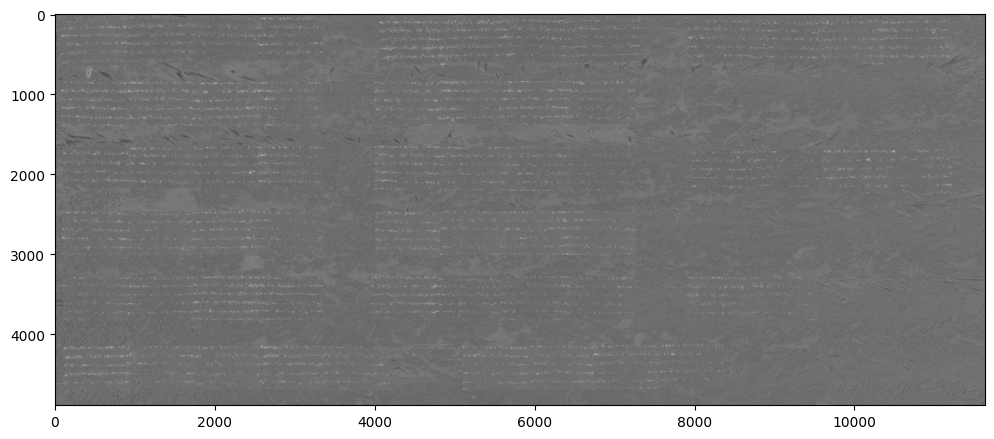

In [ ]:
showimg(exgi,(12,8),cmap="gray")

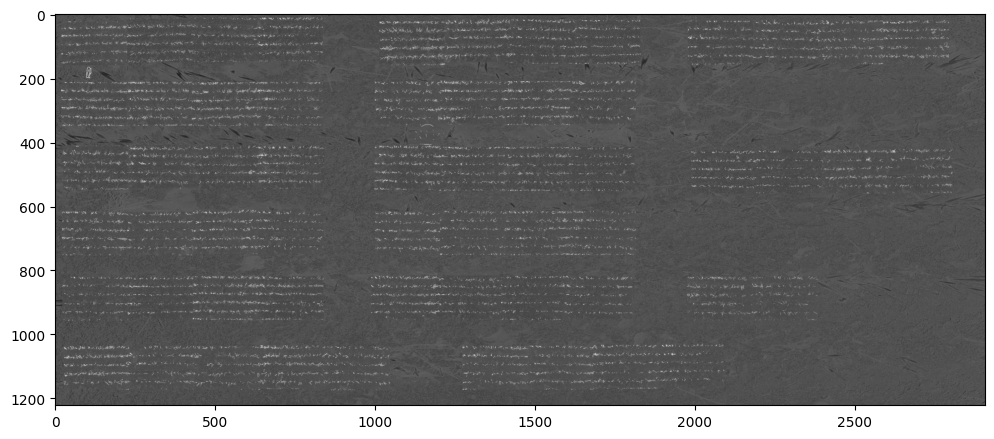

In [ ]:
factor = 4
small_img = block_reduce(exgi, block_size=(factor, factor), func=np.max)
showimg(small_img)

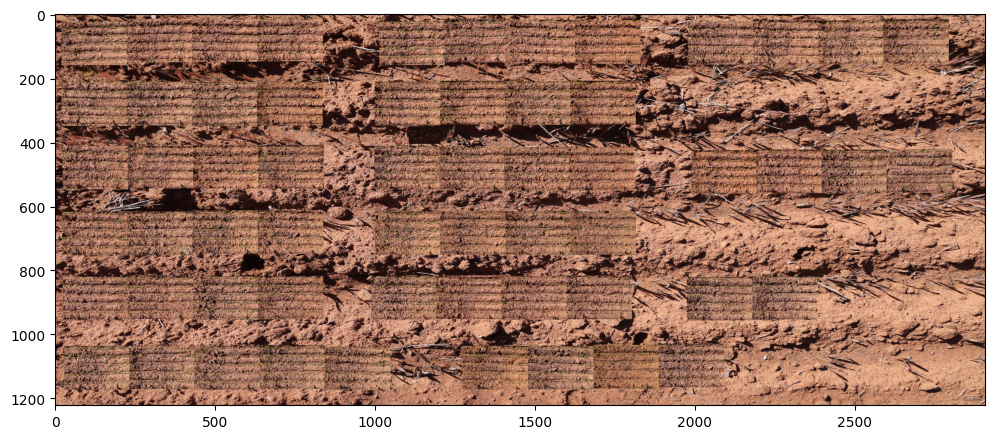

In [ ]:
small_rgb = cv2.resize(orig, (small_img.shape[1], small_img.shape[0]))
showimg(small_rgb,cmap=None)

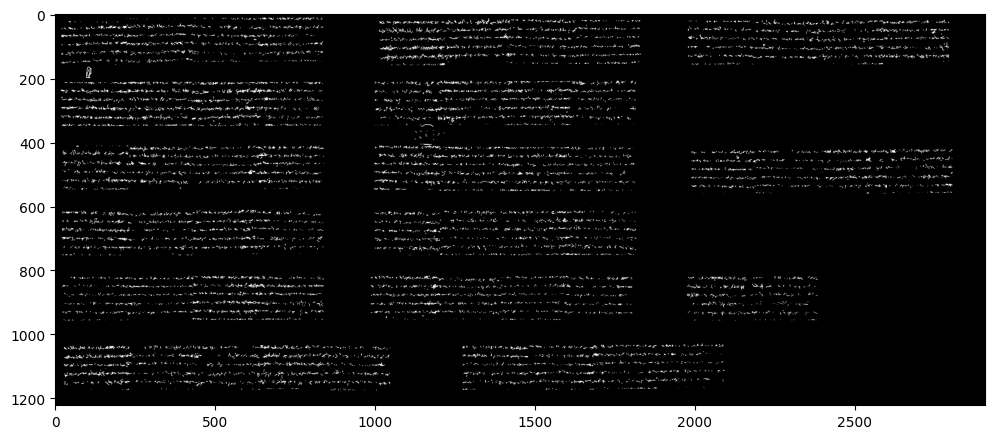

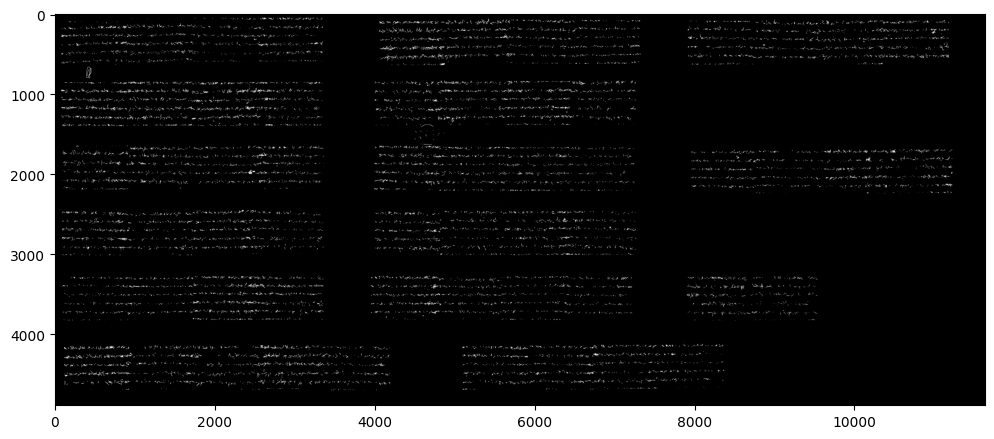

In [ ]:
_, bin = cv2.threshold(small_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
showimg(bin)
_, orig_bin = cv2.threshold(exgi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
showimg(orig_bin)

In [ ]:
def pad_image(image, border_width):
    return cv2.copyMakeBorder(
        image, top=border_width, bottom=border_width, left=border_width, right=border_width,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )

def find_plots_preprocess(bin, close_range=45, max_weed_patch_size=70):
    pad_w = max(close_range, max_weed_patch_size) + 1
    bin = pad_image(bin, pad_w)
    showimg(bin)
    s1 = cv2.morphologyEx(bin, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (close_range, close_range)))
    showimg(s1)
    s2 = cv2.morphologyEx(s1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (max_weed_patch_size, max_weed_patch_size)))
    showimg(s2)
    s3 = s2[pad_w:-pad_w, pad_w:-pad_w]
    showimg(s3)
    return s3

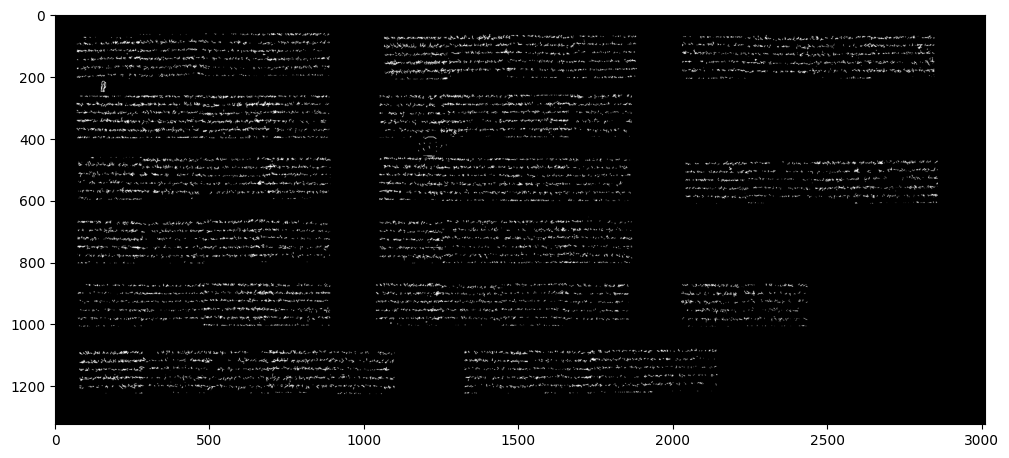

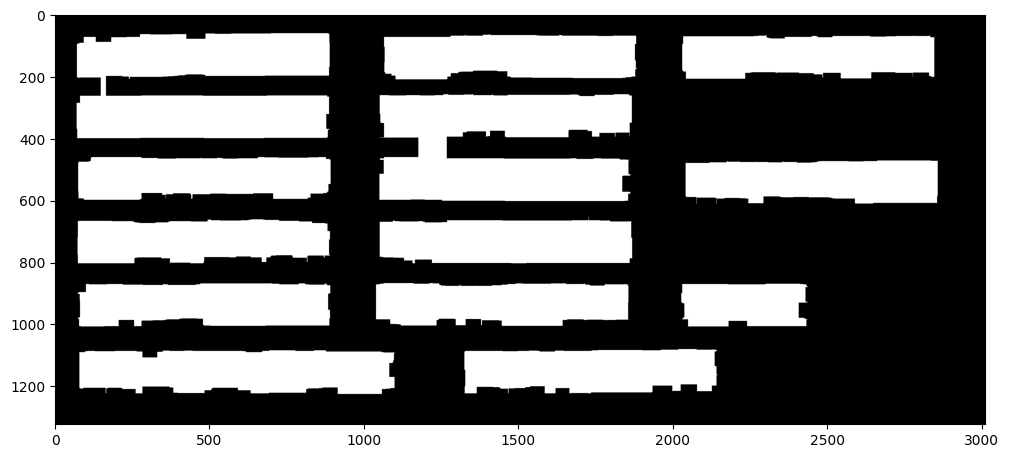

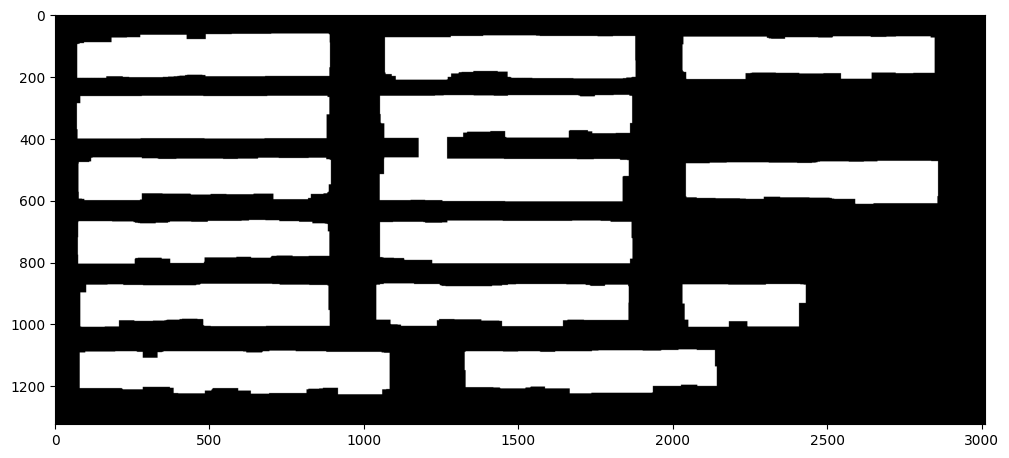

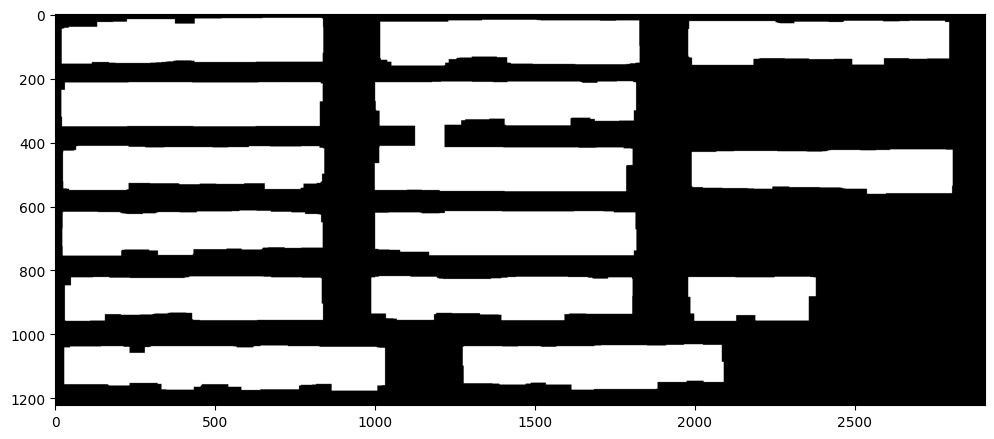

In [ ]:
img=find_plots_preprocess(bin, close_range=45, max_weed_patch_size=50)

In [ ]:
def find_rectangles(bin_image, w_h_ratio, r_tolerance, exp_h, w_tolerance, annotate_on=None):
    colored = cv2.cvtColor(bin_image, cv2.COLOR_GRAY2RGB) if annotate_on is None else annotate_on
    edged = cv2.Canny(bin_image, 30, 150)
    showimg(edged)

    whr_lower_1 = w_h_ratio / (1 + r_tolerance)
    whr_upper_1 = w_h_ratio * (1 + r_tolerance)
    whr_lower_2 = 1 / whr_upper_1
    whr_upper_2 = 1 / whr_lower_1
    exp_w_lower = exp_h / (1 + w_tolerance)
    exp_w_upper = exp_h * (1 + w_tolerance)
    # show_img(edged)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(colored, (x, y), (x + w, y + h), (255, 0, 255), 2)
        cv2.putText(colored, f"{w}-{h}", (x,y), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255),2)
        cv2.drawContours(colored, [contour], 0, (0, 255, 0), 2)
        aspect_ratio = w / float(h)
        m = np.min([w, h])
        if m < exp_w_lower or m > exp_w_upper:
            continue
        if (aspect_ratio > whr_lower_1 and aspect_ratio < whr_upper_1) or \
                (aspect_ratio > whr_lower_2 and aspect_ratio < whr_upper_2):
            rectangles.append([x,y,w,h])
            cv2.rectangle(colored, (x, y), (x + w, y + h), (255, 0, 0), 3)

    showimg(colored)
    return rectangles

def find_span(image, ox, oy):
    minx, maxx, miny, maxy = ox, ox, oy, oy
    limx, limy = image.shape[1]-1, image.shape[0]-1
    while minx > 0 and image[oy, minx] > 0:
        minx -= 1
    while miny > 0 and image[miny, ox] > 0:
        miny -= 1
    while maxx < limx and image[oy, maxx] > 0:
        maxx += 1
    while maxy < limy and image[maxy, ox] > 0:
        maxy += 1
    return minx, miny, maxx, maxy
    

def find_rectangles2(bin_image, w_h_ratio, r_tolerance, exp_h, w_tolerance, annotate_on=None):    
    whr_lower_1 = w_h_ratio / (1 + r_tolerance)
    whr_upper_1 = w_h_ratio * (1 + r_tolerance)
    whr_lower_2 = 1 / whr_upper_1
    whr_upper_2 = 1 / whr_lower_1
    exp_w_lower = exp_h / (1 + w_tolerance)
    exp_w_upper = exp_h * (1 + w_tolerance)
    
    c=8
    step=max(1,min(exp_h*w_h_ratio//c,exp_h//c))
    expected_count = exp_h * exp_h * w_h_ratio / step / step
    print(f"step={step}  tot={bin_image.shape[0]//c*bin_image.shape[1]//c}  expected={expected_count}")
    
    counter = np.zeros(bin_image.shape)
    for y in range(0, bin_image.shape[0], step):
        for x in range(0, bin_image.shape[1], step):
            x1, y1, x2, y2 = find_span(bin_image, x, y)
            spanw,spanh=x2-x1, y2-y1
            if spanw * spanh == 0:
                continue
            m = np.min([spanw, spanh])
            if m < exp_w_lower or m > exp_w_upper:
                continue
            aspect_ratio = spanw / float(spanh)
            if (aspect_ratio > whr_lower_1 and aspect_ratio < whr_upper_1) or \
                    (aspect_ratio > whr_lower_2 and aspect_ratio < whr_upper_2):
                counter[y1:y2+1, x1:x2+1] += 1
    showimg(np.array(cv2.normalize(counter, None, 0, 255, cv2.NORM_MINMAX), dtype=np.uint8), (40,40))
    print(f"levels: {np.unique(counter)}")
    counter = np.where(counter > expected_count/10, 255, 0)
    showimg(counter,(40,40))
    counter = np.array(counter, dtype=np.uint8)
    return find_rectangles(counter, w_h_ratio, r_tolerance, exp_h, w_tolerance, annotate_on)


step=18  tot=55252  expected=379.6296296296296


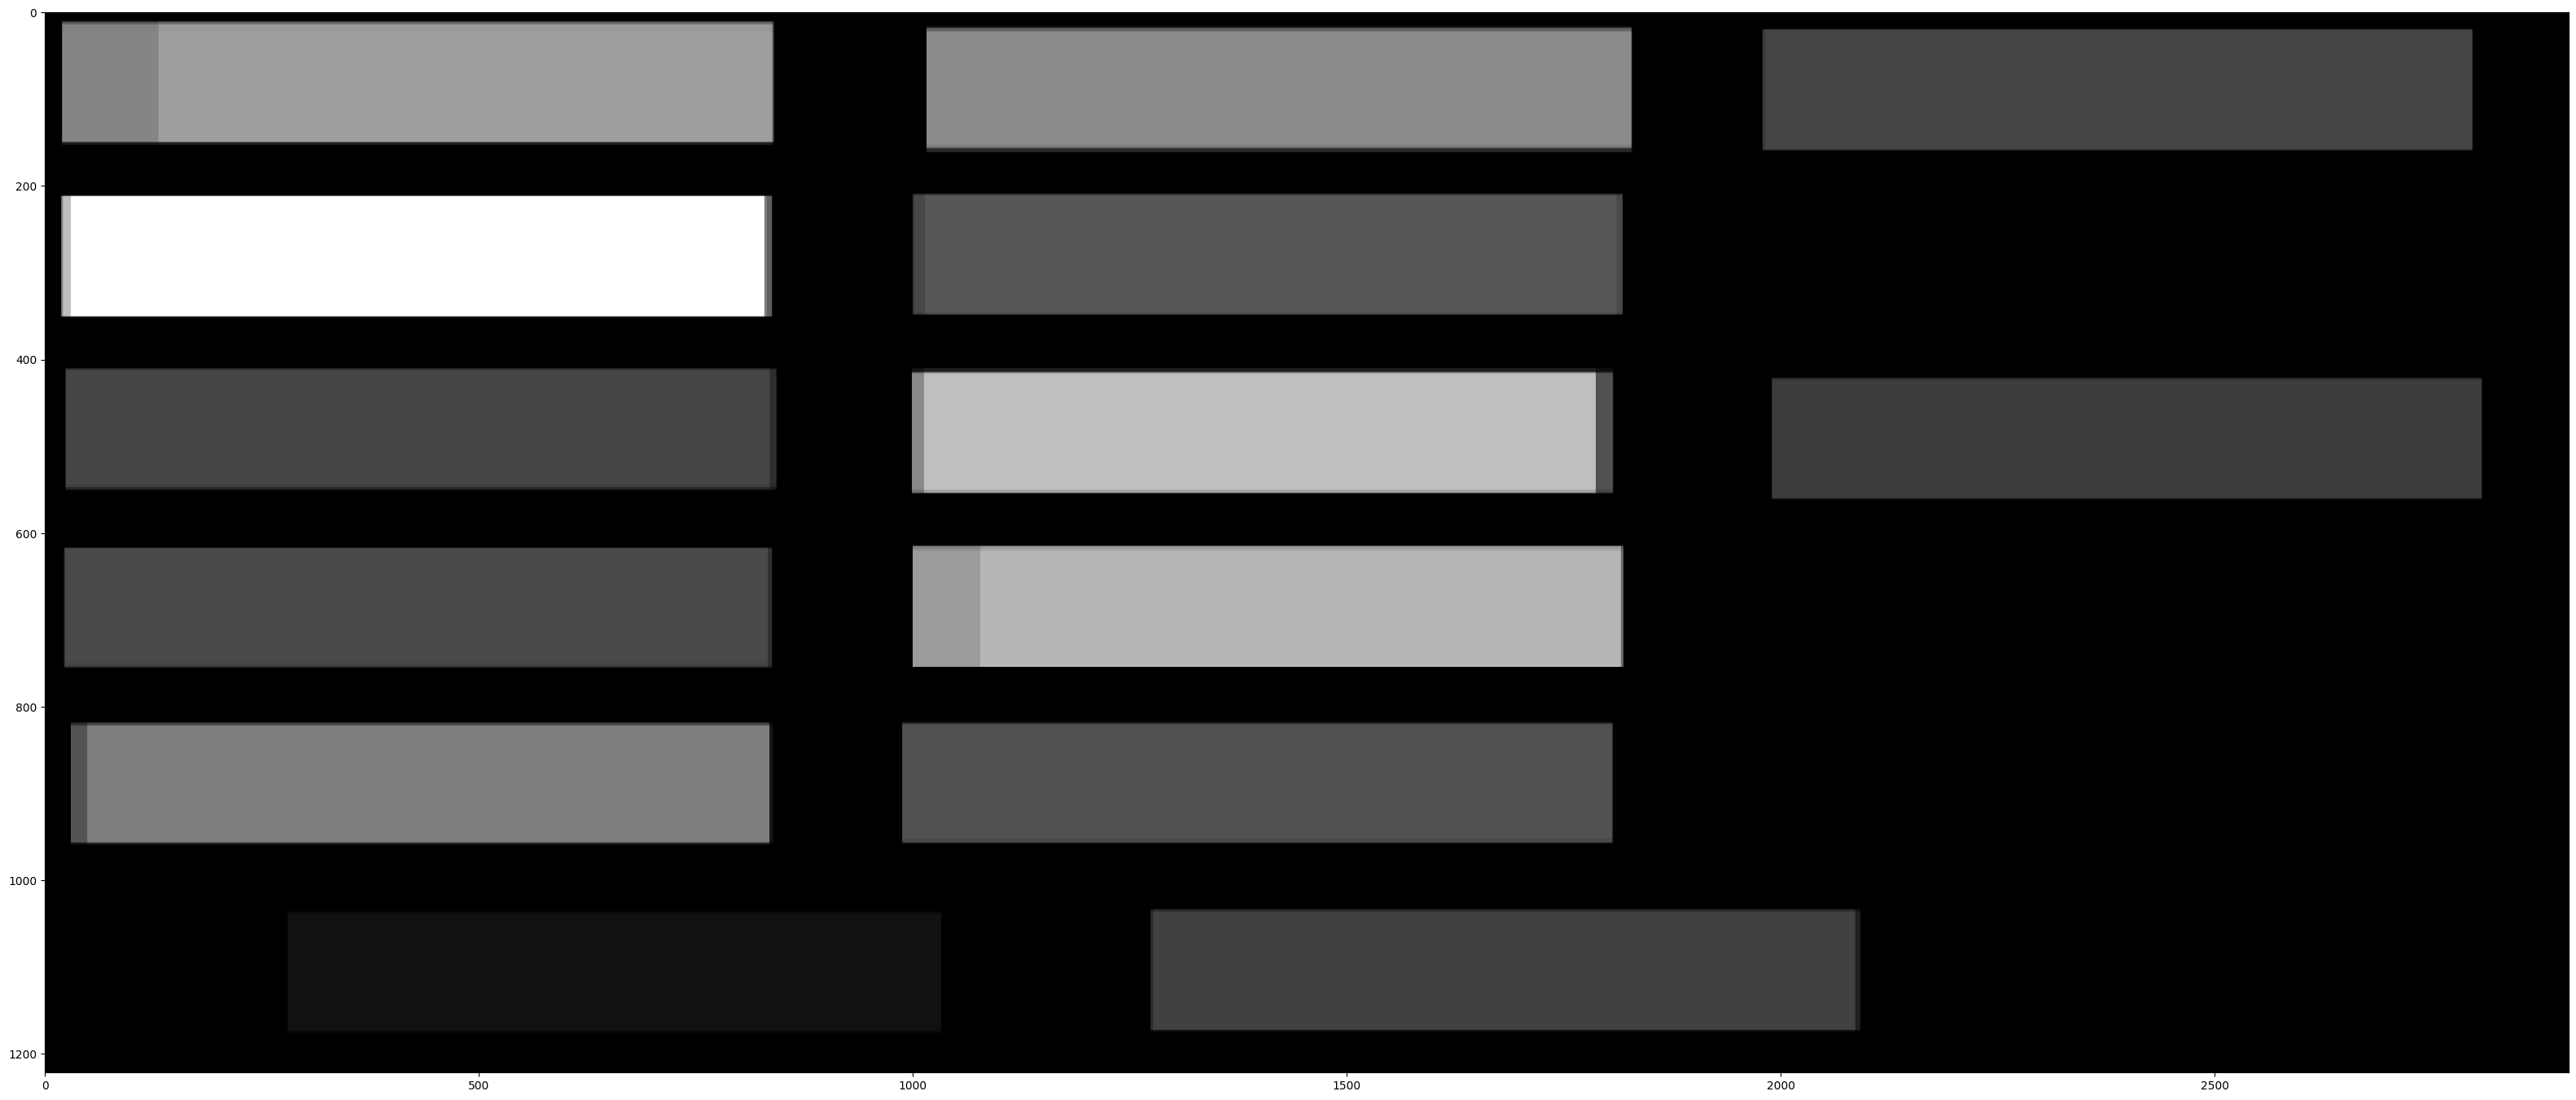

levels: [  0.   4.   5.   6.   7.  10.  12.  13.  14.  15.  16.  18.  20.  22.
  23.  24.  25.  28.  29.  30.  32.  33.  34.  36.  40.  42.  44.  45.
  46.  48.  49.  50.  51.  52.  54.  55.  56.  57.  58.  60.  63.  64.
  66.  68.  70.  72.  75.  78.  80.  84.  85.  88.  90.  96.  99. 100.
 102. 105. 106. 108. 110. 111. 112. 114. 116. 120. 126. 128. 132. 136.
 138. 144. 147. 150. 152. 154. 155. 156. 160. 165. 168. 174. 176. 178.
 180. 184. 185. 190. 192. 198. 204. 210. 212. 216. 219. 224. 231. 238.
 252. 259. 264. 266. 352.]


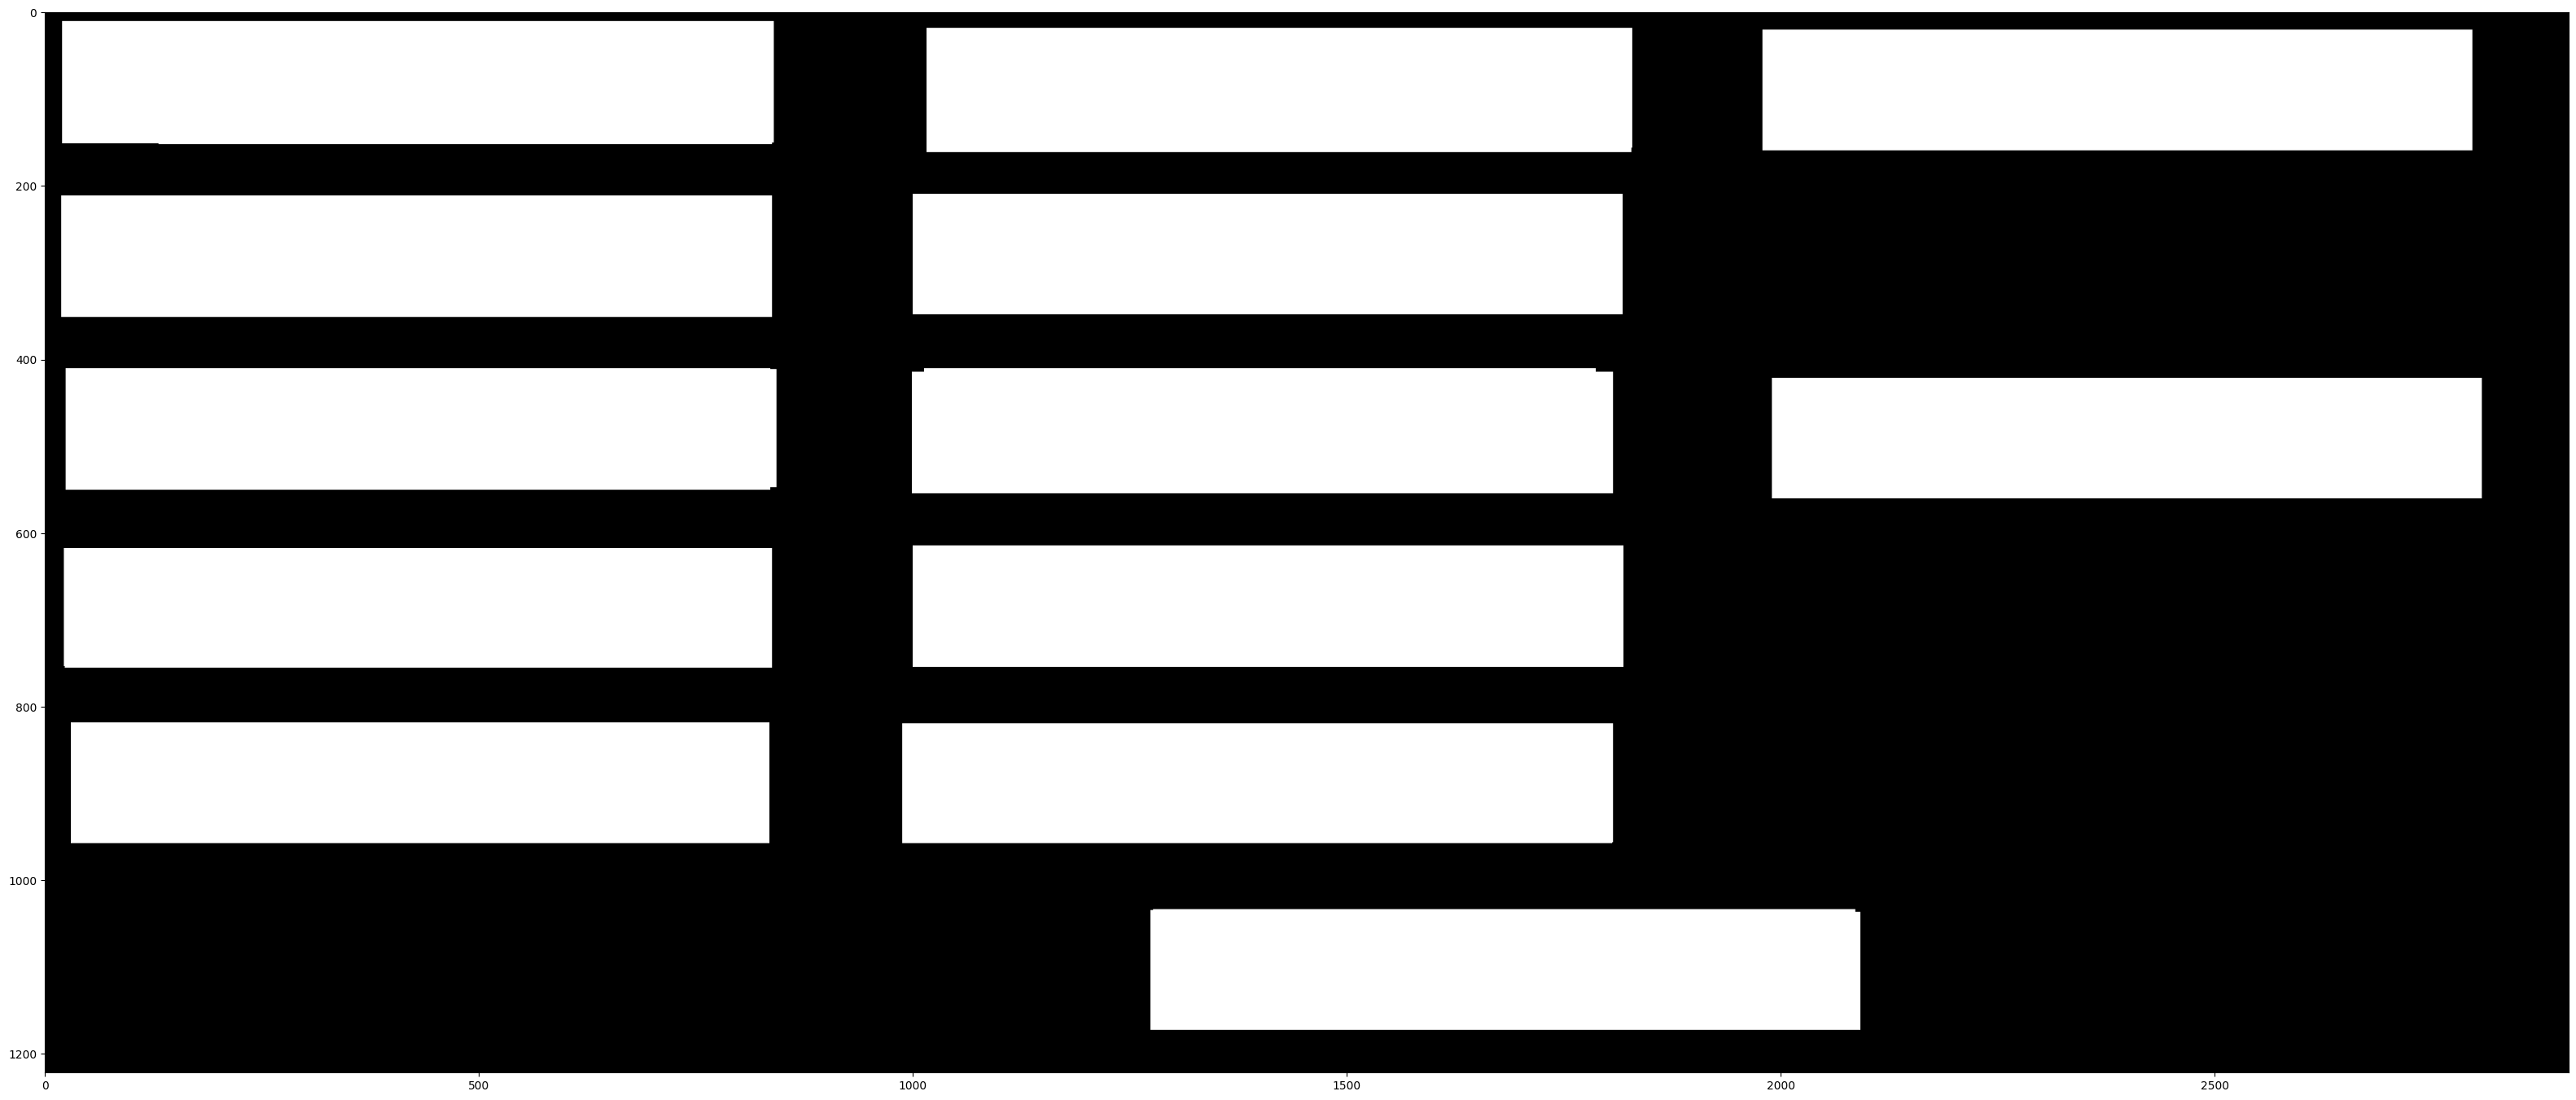

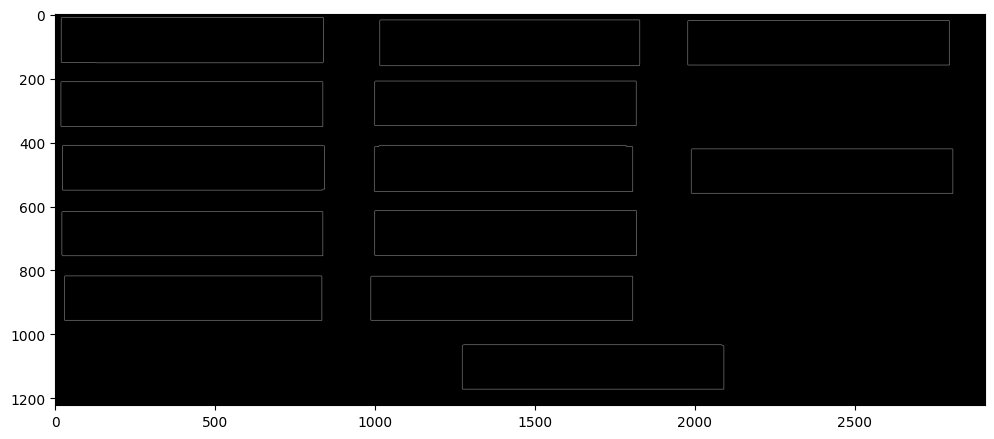

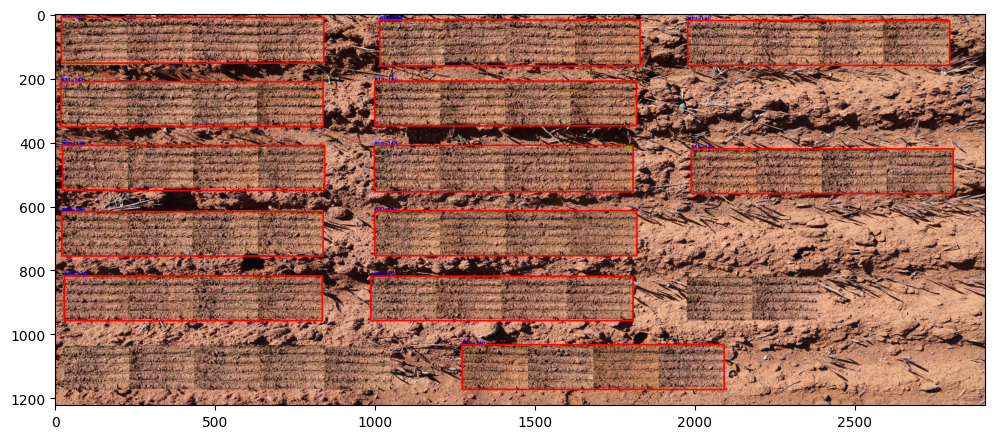

In [ ]:
rects = find_rectangles2(img, 820 / 150, 0.15, 150, 0.2
                    , cv2.resize(orig, dsize=(0, 0), fx=1 / factor, fy=1 / factor)
                    )
